# About the Project



# Import Dependencies

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from datetime import datetime
from zipfile import ZipFile

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer


In [ ]:
!pip install pyod
from pyod.models.cblof import CBLOF
from numpy import percentile
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190289 sha256=8c5928b8990cb515e56432c0b06526bc04f40b67ad532737c6155040e0dc32e3
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


# Data

## Import Tensorflow Dataset (df)

Source: https://www.tensorflow.org/tutorials/structured_data/time_series

A weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 15 different features including time, air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.


**Key Features, sourced from https://keras.io/examples/timeseries/timeseries_weather_forecasting/:**

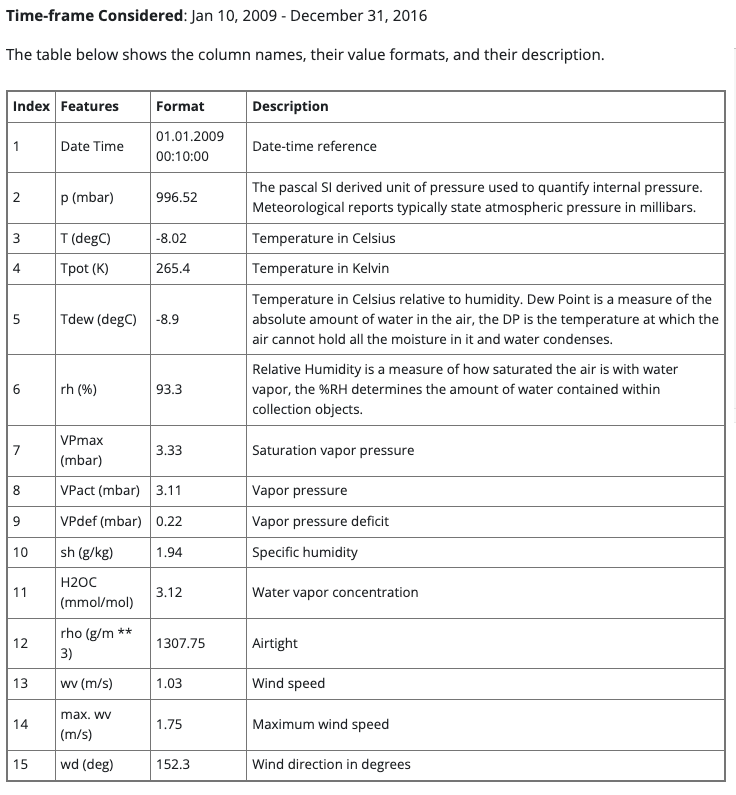



In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)



13568290/13568290 [==============================] - 0s 0us/step


In [ ]:
# Get the dataset
df = pd.read_csv(csv_path)

In [ ]:
# save for Anomaly Detection Method 1: k-NN
train_df = train_df2 = train_df3 = pd.read_csv(csv_path)

# We took the dates out of the dataframe, so that it has only 14 coloumns of features, and created a seperate dataframe called date_time to link row index with the date
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

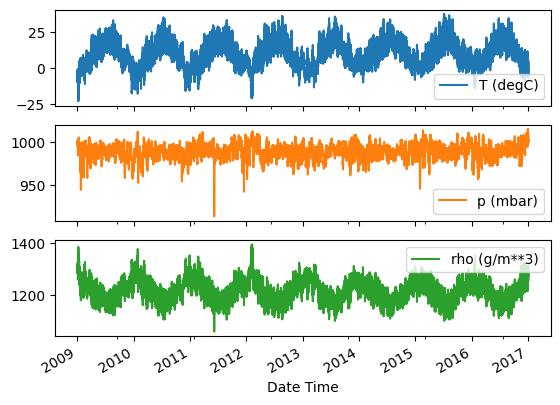

In [ ]:
# Visulalise Data

# This show the yearly trends for temperature, pressure and rho
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


## Data inspection


In [ ]:
# show the first few data points
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
# identify the datatypes for the different features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 44.9 MB


In [ ]:
# check a statistical summary of the dataset
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


The data inspection process has shown that there are 70091 data points, each with 14 features od datatype float64. This process will inform the data cleaning and formatting process:


*   the minumum values for wind velocity are -9999, which is a likely error that needs to be removed
*   airtight (rho), windvelocities (wv, max wv) and wind directions (wd) all have much larger standard deviations than the other features. This might make them more relevant.

## Data Cleaning

In [ ]:
# identify and remove the missing datapoints
missing = df.isnull().sum() # there are no null values to clean up
# remove outliers in wv and max.wv columns
df['wv (m/s)'] = df['wv (m/s)'].replace(-9999.0, 1.702567	)
df['max. wv (m/s)'] = df['max. wv (m/s)'].replace(-9999.0, 2.963041)


## Data Formatting



In [ ]:
# Rounding up the float64 data to 2 decimal points.
floats = df.select_dtypes(include='float')
df[floats.columns] = floats.round(2)

In [ ]:
# format date and time column to make grouping years and seasons easier

# add time column
df["Time"] = [data.time() for data in date_time]
df["Time"]= df["Time"].astype(str)

# add date column
df["Date"] = [data.date() for data in date_time]
df["Date"]= df["Date"].astype(str)

# add year, month, day columns
df["Year"] = df["Date"].str.split('-').str[0].astype(int)
df["Month"] = df["Date"].str.split('-').str[1].astype(int)
df["Day"] = df["Date"].str.split('-').str[2].astype(int)


In [ ]:
# check that the outliers have been removed and the new columns have been added
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Year,Month,Day
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,2.130264,3.532215,174.743738,2012.496813,6.517307,15.713324
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,1.542274,2.340358,86.681693,2.289760,3.448322,8.799093
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000,2009.000000,1.000000,1.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000,2010.000000,4.000000,8.000000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000,2012.000000,7.000000,16.000000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000,2014.000000,10.000000,23.000000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000,2017.000000,12.000000,31.000000


## Multivariate Analysis

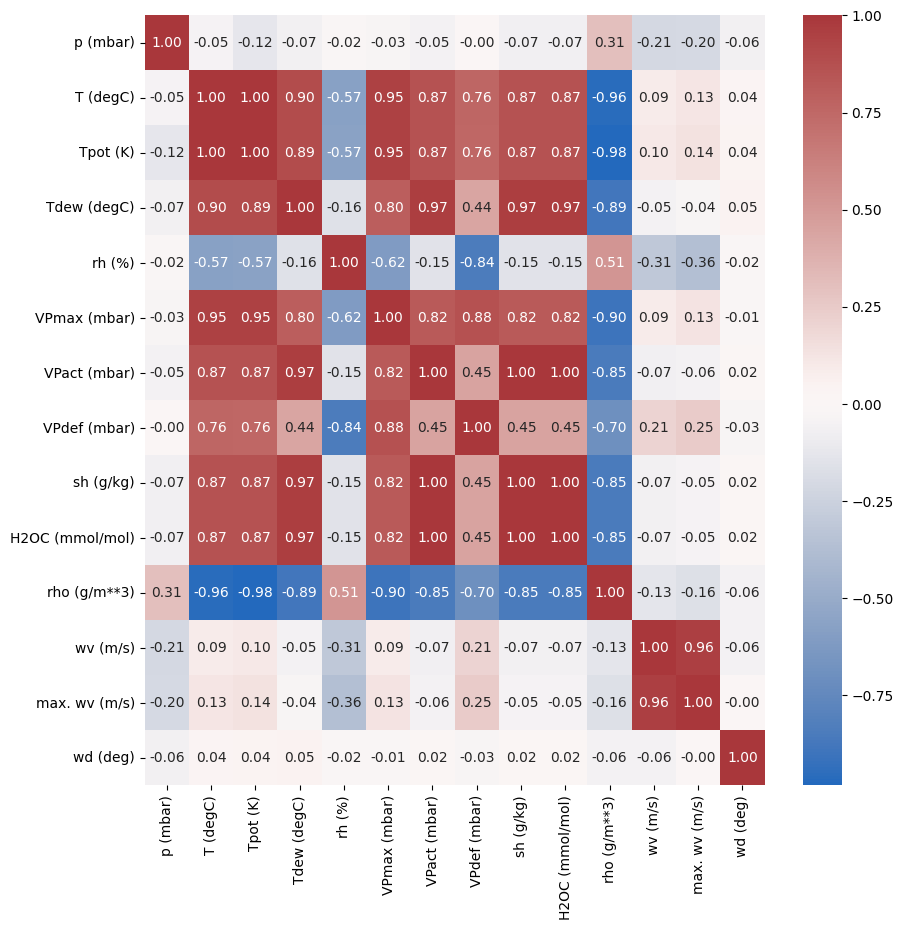

In [ ]:
# plot heatmap to show correlation between the 14 numerical features

plt.figure(figsize=(10, 10))
corr = df.iloc[:, 0:14].corr()
sns.heatmap(corr, annot=True, cmap = 'vlag', fmt=".2f")
plt.show()

## Create subsections of the dataset

### Weather Years (for k-NN, Z-score and CBLOF methods)

In [ ]:
# iterate through each unique year to create subesections of the dataset
year_data = {f'y{year}': df.loc[df['Year'] == year] for year in df['Year'].unique()}


### Weather Days (for Autoencoder method)

In [ ]:
# weather-days (takes a long time to run!)

# iterate through each unique day to create subesections of the dataset
day_data = {f'd{date}': df.loc[df['Date'] == date] for date in df['Date'].unique()}


In [ ]:
# split the days in day_data based on their years (names). make new year dictionaries


# create sub dictionaries for every year
year_dicts = ['2009','2010', '2011','2012','2013','2014','2015','2016']

# Create a result dictionary with empty sub-dictionaries for each pattern
year_day_data = {year: {} for year in year_dicts}

# iterate through the original dictionary and match keys to patterns
for key, value in day_data.items():
    for year in year_dicts:
        if year in key:
            year_day_data[year][key] = value

In [ ]:
# initialize an empty list to store separate temperature DataFrames
temperature_dfs = []

# iterate through each dictionary
for dataframes_dict in year_day_data.values():
    # initialize an empty list to store temperature DataFrames from the current dictionary
    temp_dfs = []

    # Iterate through the dictionary and extract the 'temperature' column from each DataFrame
    for key, df in dataframes_dict.items():
        if 'Tpot (K)' in df.columns:
            temp_dfs.append(list(df['Tpot (K)']))

    # combine the temperature DataFrames from the current dictionary into one DataFrame
    combined_temp_df = pd.DataFrame(temp_dfs)

    # Append the combined DataFrame to the list of separate temperature DataFrames
    temperature_dfs.append(combined_temp_df)

# Now, temperature_dfs is a list of separate DataFrames, each containing the "temperature" column data
# You can access them as temperature_dfs[0], temperature_dfs[1], etc.

# Print the separate DataFrames
for i, df in enumerate(temperature_dfs, 1):
  # Remove columns with NaN values
    df = df.dropna(axis=1)
    print(f"Temperature DataFrame {2008 + i}:\n{df}")

Temperature DataFrame 2009:
        0       1       2       3       4       5       6       7       8    \
0    265.40  265.01  264.91  265.12  265.15  265.38  265.81  265.81  265.52   
1    268.65  268.60  268.53  268.53  268.65  268.77  268.77  268.82  268.82   
2    268.27  268.09  267.78  267.49  267.48  267.55  267.70  267.58  267.32   
3    271.81  271.89  272.03  272.14  272.19  272.29  272.35  272.28  271.77   
4    272.86  272.83  272.81  272.78  272.78  272.78  272.79  272.79  272.79   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
360  274.11  273.98  274.00  273.93  273.87  273.84  273.74  273.66  273.61   
361  276.69  276.57  276.64  276.78  276.84  276.85  276.88  276.88  276.81   
362  272.60  272.56  272.47  272.41  272.61  272.51  272.19  271.80  271.42   
363  274.72  274.77  274.77  274.85  274.92  274.99  275.04  275.08  275.10   
364  275.10  275.10  275.07  275.04  275.04  275.04  275.10  275.10  275.04   

        9    ...     13

In [ ]:
# Next, we combined the individual dataframes of daily temperature data for each year into one big dataframe
# and added a labels column indicating if that year was anomalous acording to its z-score (greater than 3)

# 2014, 2015 are anomalous (see Anomaly Detection Method 2, Z-score) so they have the label 1
anomalous_df = pd.concat([temperature_dfs[5], temperature_dfs[6]]).reset_index(drop=True)
anomalous_df['labels'] = 1

# the other temperature dataframes are nonanamalous, and so have the label 0
nonanomalous_df = pd.concat([temperature_dfs[0], temperature_dfs[1],temperature_dfs[2],temperature_dfs[3],temperature_dfs[4],temperature_dfs[7]]).reset_index(drop=True)
nonanomalous_df['labels'] = 0

# combine to make one dataframe of all the daily temperature data for every year
full_temp_df = pd.concat([anomalous_df.dropna(axis=1), nonanomalous_df.dropna(axis=1)]).reset_index(drop=True)

# because 2016 only has temperature data for the first part of the year,
# we only consider the first parts of each years teamperature data

# remove columns with NaN values
full_temp_df = full_temp_df.dropna(axis =1)


In [ ]:
# Now we have the temperature data formatted for the autoencoder!
full_temp_df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,labels
0,274.01,274.03,274.08,274.10,274.37,274.62,274.84,274.97,275.18,275.38,...,275.64,275.66,275.49,275.46,275.46,275.38,275.30,275.22,275.27,1
1,276.70,276.54,276.47,276.43,276.42,276.47,276.59,276.77,276.94,277.13,...,278.63,278.59,278.66,278.56,278.54,278.55,278.55,278.67,278.72,1
2,280.25,279.92,279.61,279.37,279.29,279.85,279.44,278.84,278.59,278.46,...,278.22,278.28,278.46,278.73,278.79,278.76,278.77,278.83,278.89,1
3,284.73,284.67,284.54,284.35,284.20,284.04,283.77,283.67,283.68,283.65,...,279.80,279.65,279.64,279.81,280.08,280.24,280.30,280.35,280.46,1
4,281.90,281.89,281.78,281.73,281.74,281.73,281.73,281.74,281.91,281.96,...,281.40,281.67,282.06,282.25,282.39,282.43,282.49,282.46,282.57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,276.39,276.46,276.46,276.33,276.30,276.30,276.27,276.30,276.31,276.42,...,277.41,277.51,277.74,277.91,277.83,277.81,277.82,278.03,278.41,0
2916,278.53,278.51,278.52,278.51,278.50,278.50,278.43,278.42,278.43,278.38,...,276.98,277.00,277.03,277.04,277.07,277.13,277.12,277.18,277.19,0
2917,275.47,275.37,275.39,275.54,275.45,275.39,275.36,275.33,275.32,275.31,...,274.61,274.71,274.79,274.83,274.94,275.04,275.02,275.06,275.24,0
2918,270.37,270.39,270.24,270.17,270.14,270.14,269.96,269.90,269.90,269.79,...,267.41,267.24,267.68,267.98,268.10,268.26,268.34,268.56,268.85,0


# Anomaly Detection Method 1: k-NN

The k-Nearest Neighbors algorithm, (k-NN) is a supervised machine learning algorithm that is widely used to solve classification problems. k-NN algorithm assumes that similar things exist in close proximity.  

In [ ]:
# the first few rows of the dataset
train_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
# the shape of the dataset (rows x columns)
train_df.shape

(420551, 15)

In [ ]:
# show columns
train_df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [ ]:
# get more information about the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


## Data analysis

In [ ]:
# mean temperature
average_temperature = train_df['T (degC)'].mean()
print("Average Temperature:", average_temperature)

Average Temperature: 9.450147354304233


In [ ]:
# The highest and lowest temperatures

max_temperature = train_df['T (degC)'].max()
min_temperature = train_df['T (degC)'].min()

print("Highest Temperature:", max_temperature)
print("Lowest Temperature:", min_temperature)

Highest Temperature: 37.28
Lowest Temperature: -23.01


In [ ]:
# Calculate the average humidity
average_humidity = train_df['rh (%)'].mean()
print("Average Humidity:", average_humidity)

Average Humidity: 76.0082594025457


In [ ]:
# takes a long time to run!

# Parse date and create a 'Year' column
train_df['Year'] = pd.to_datetime(train_df['Date Time'], format='%d.%m.%Y %H:%M:%S').dt.year

# Filter data for the year 2009
train_df = train_df[train_df['Year'] == 2009]

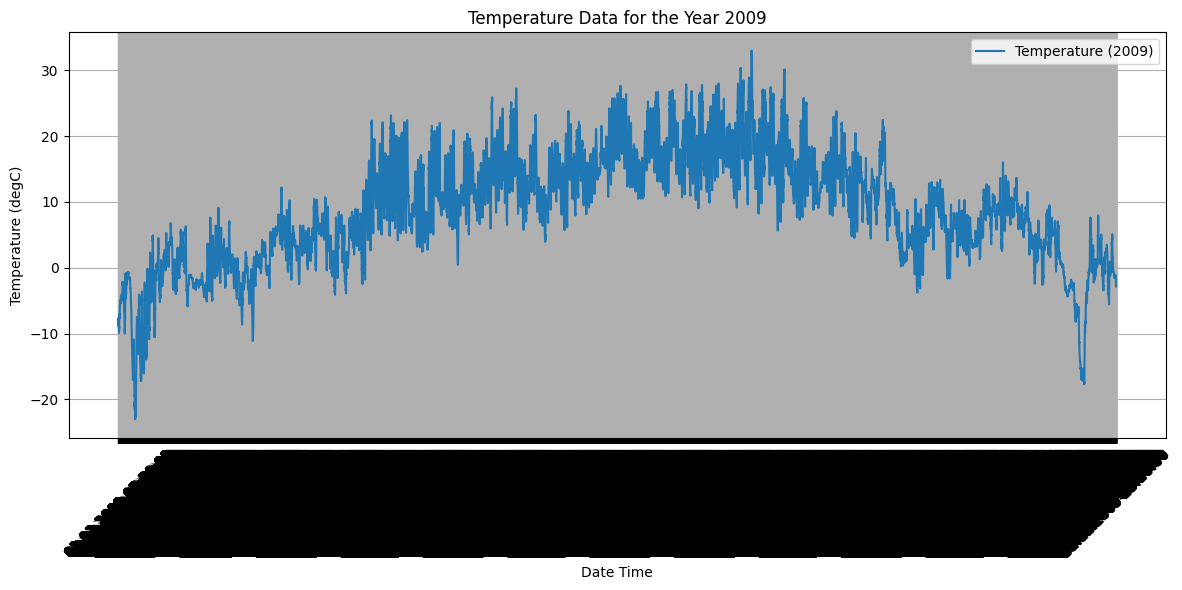

In [ ]:
# Create a line plot of temperature data for 2009
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date Time'], train_df['T (degC)'], label='Temperature (2009)')
plt.xlabel('Date Time')
plt.ylabel('Temperature (degC)')
plt.title('Temperature Data for the Year 2009')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

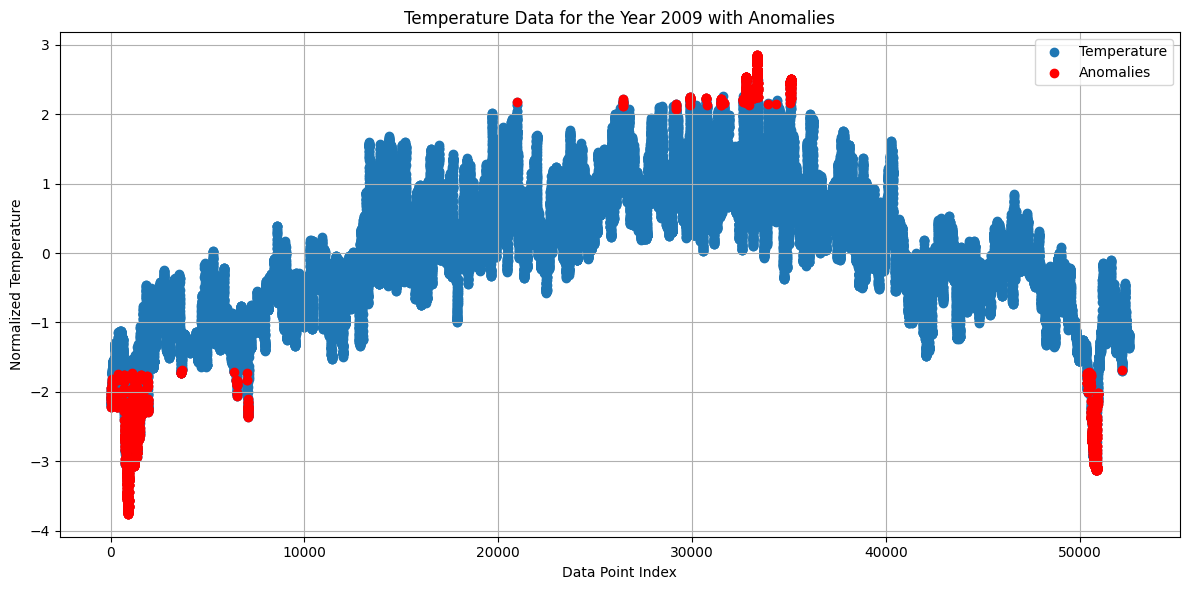

Anomalies for the year 2009:
                 Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
1      01.01.2009 00:20:00    996.57 -2.034065    265.01        -9.28    93.4   
1      01.01.2009 00:20:00    996.57 -2.034065    265.01        -9.28    93.4   
3      01.01.2009 00:40:00    996.51 -2.022267    265.12        -9.07    94.2   
5      01.01.2009 01:00:00    996.50 -1.991591    265.38        -8.78    94.4   
6      01.01.2009 01:10:00    996.50 -1.940858    265.81        -8.30    94.8   
...                    ...       ...       ...       ...          ...     ...   
50940  20.12.2009 18:30:00    971.46 -2.011648    267.14       -11.65    76.1   
50949  20.12.2009 20:00:00    970.47 -2.024626    267.11       -11.58    77.2   
50949  20.12.2009 20:00:00    970.47 -2.024626    267.11       -11.58    77.2   
50950  20.12.2009 20:10:00    970.46 -2.009289    267.24       -11.42    77.4   
52183  29.12.2009 09:40:00    981.02 -1.686014    269.17        -5.88    96.8   

In [ ]:
# Filter data for the year 2009
train_df1 = train_df[train_df['Year'] == 2009]

# Remove unnecessary columns
train_df1 = train_df[['Year', 'T (degC)']]

# Normalize temperature values
scaler = StandardScaler()
train_df['T (degC)'] = scaler.fit_transform(train_df[['T (degC)']])

# Choose an appropriate value of k (number of neighbors)
k = 5

# Train KNN model
knn = NearestNeighbors(n_neighbors=k)
knn.fit(train_df[['T (degC)']])

# Detect Anomalies
distances, _ = knn.kneighbors(train_df[['T (degC)']])
# Calculate z-scores for distances
z_scores = ((distances - distances.mean()) / distances.std())

# Define a threshold for anomaly detection
anomaly_threshold = 2.0  # Adjust as needed

# Identify anomalies
anomalies = train_df[z_scores > anomaly_threshold]

# Create a line plot of temperature data for 2009
plt.figure(figsize=(12, 6))
plt.scatter(train_df.index, train_df['T (degC)'], label='Temperature')
plt.scatter(anomalies.index, anomalies['T (degC)'], c='red', label='Anomalies')
plt.xlabel('Data Point Index')
plt.ylabel('Normalized Temperature')
plt.title('Temperature Data for the Year 2009 with Anomalies')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

print(f'Anomalies for the year 2009:')
print(anomalies)

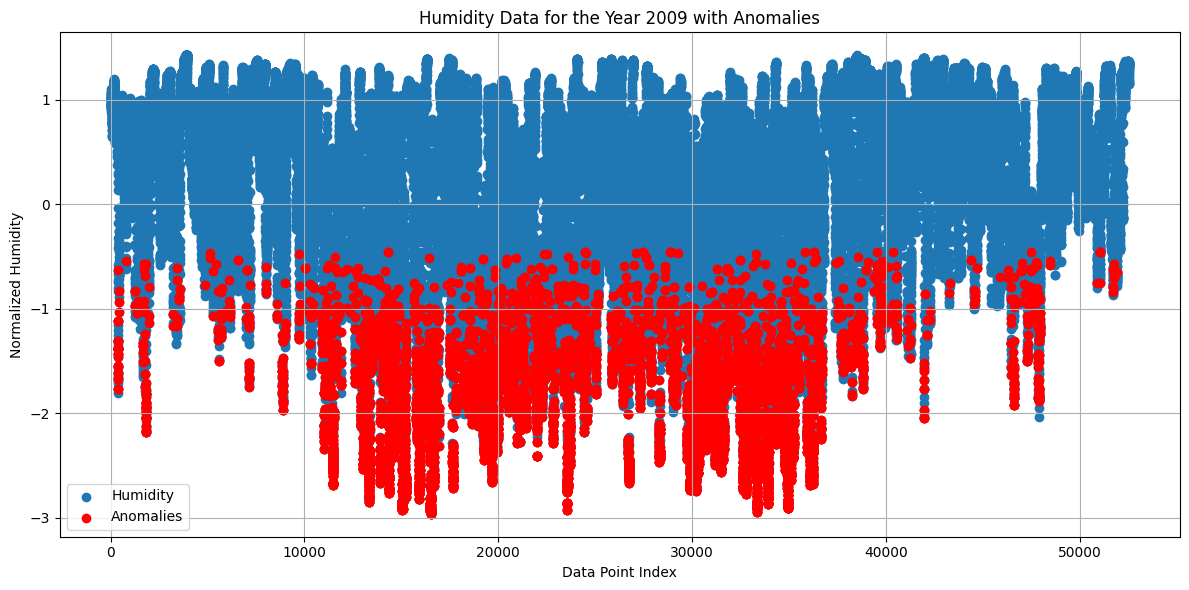

Anomalies in Humidity for the year 2009:
       Year    rh (%)
367    2009 -0.624619
374    2009 -1.371397
374    2009 -1.371397
375    2009 -1.380787
375    2009 -1.380787
...     ...       ...
51774  2009 -0.694102
51774  2009 -0.694102
51778  2009 -0.624619
51784  2009 -0.576420
51917  2009 -0.647780

[10176 rows x 2 columns]


In [ ]:
# Parse date and create a 'Year' column
train_df2['Year'] = pd.to_datetime(train_df2['Date Time'], format='%d.%m.%Y %H:%M:%S').dt.year

# Filter data for the year 2009
train_df2 = train_df2[train_df2['Year'] == 2009]

# Remove unnecessary columns
train_df2 = train_df2[['Year', 'rh (%)']]  # Select 'Year' and 'rh (%)' columns for humidity

# Normalize humidity values
scaler = StandardScaler()
train_df2['rh (%)'] = scaler.fit_transform(train_df2[['rh (%)']])

# Choose an appropriate value of k (number of neighbors)
k = 5

# Train KNN model
knn = NearestNeighbors(n_neighbors=k)
knn.fit(train_df2[['rh (%)']])

# Detect Anomalies for Humidity
distances, _ = knn.kneighbors(train_df2[['rh (%)']])
# Calculate z-scores for distances
z_scores = ((distances - distances.mean()) / distances.std())

# Define a threshold for anomaly detection
anomaly_threshold = 2.0  # Adjust as needed

# Identify anomalies for Humidity
anomalies_humidity = train_df2[z_scores > anomaly_threshold]

# Plot the humidity data with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.scatter(train_df2.index, train_df2['rh (%)'], label='Humidity')
plt.scatter(anomalies_humidity.index, anomalies_humidity['rh (%)'], c='red', label='Anomalies')
plt.xlabel('Data Point Index')
plt.ylabel('Normalized Humidity')
plt.title('Humidity Data for the Year 2009 with Anomalies')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Print the detected anomalies for Humidity
print(f'Anomalies in Humidity for the year 2009:')
print(anomalies_humidity)

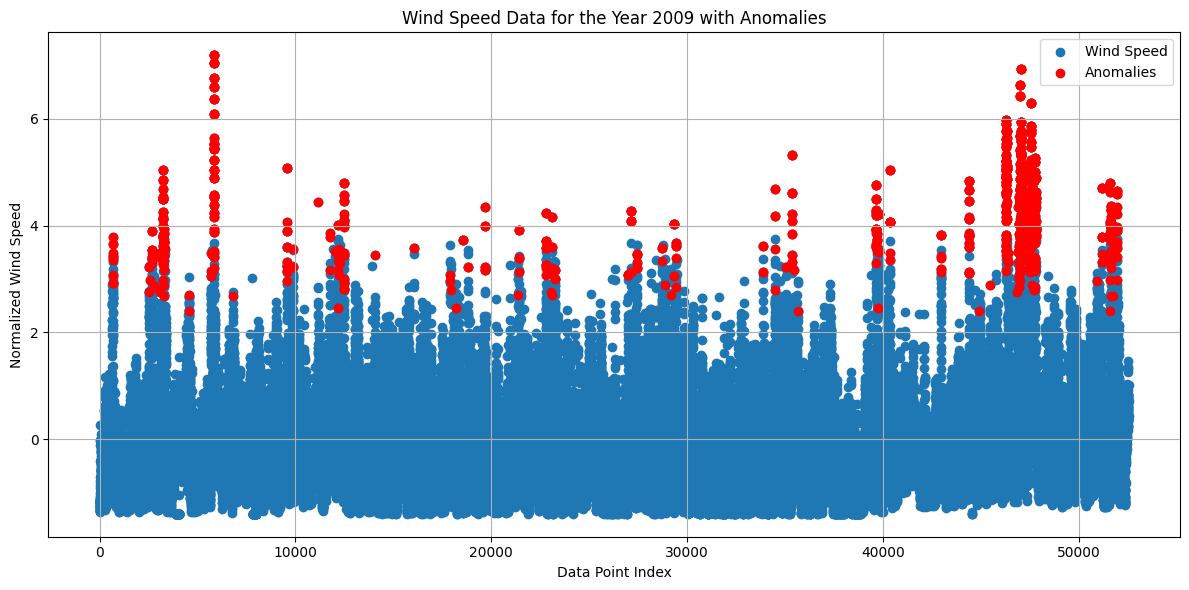

In [ ]:
# Parse date and create a 'Year' column
train_df3['Year'] = pd.to_datetime(train_df3['Date Time'], format='%d.%m.%Y %H:%M:%S').dt.year

# Filter data for the year 2009
train_df3 = train_df3[train_df3['Year'] == 2009]

# Remove unnecessary columns
train_df3 = train_df3[['Year', 'wv (m/s)']]  # Select 'Year' and 'wv (m/s)' columns for wind speed

# Normalize wind speed values
scaler = StandardScaler()
train_df3['wv (m/s)'] = scaler.fit_transform(train_df3[['wv (m/s)']])

# Choose an appropriate value of k (number of neighbors)
k = 5

# Train KNN model
knn = NearestNeighbors(n_neighbors=k)
knn.fit(train_df3[['wv (m/s)']])

# Detect Anomalies for Wind Speed
distances, _ = knn.kneighbors(train_df3[['wv (m/s)']])
# Calculate z-scores for distances
z_scores = ((distances - distances.mean()) / distances.std())

# Define a threshold for anomaly detection
anomaly_threshold = 2.0  # Adjust as needed

# Identify anomalies for Wind Speed
anomalies_wind_speed = train_df3[z_scores > anomaly_threshold]

# Plot the wind speed data with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.scatter(train_df3.index, train_df3['wv (m/s)'], label='Wind Speed')
plt.scatter(anomalies_wind_speed.index, anomalies_wind_speed['wv (m/s)'], c='red', label='Anomalies')
plt.xlabel('Data Point Index')
plt.ylabel('Normalized Wind Speed')
plt.title('Wind Speed Data for the Year 2009 with Anomalies')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Anomaly Detection Method 2: Z-score

The next few snippets are for convenience.

In [ ]:
for year in range(2009, 2017):
    key = f'y{year}'
    var_name = f'df{year}'
    globals()[var_name] = year_data[key]

Now, for example, if we run "df2009" we will get the subsection of the data corresponding to the year 2009. However, we are only interested in the temperature feature.

In [ ]:
for year in range(2009, 2017):
    df_var_name = f'df{year}'
    temp_var_name = f'temp{year}'

    globals()[temp_var_name] = globals()[df_var_name]['T (degC)']

Now, for example, if we run "temp2009" we will get the subsection of the data corresponding to the year 2009.
We can now use the SciPy library to compute the z-score values for temperature.

In [ ]:
import scipy.stats as stats
for year in range(2009, 2017):
    # Retrieve temperature data for the year
    temp_var_name = f'temp{year}'
    temp_data = globals()[temp_var_name]

    # Calculate z-scores for the temperature data
    z_scores_var_name = f'temp_z_scores{year}'
    globals()[z_scores_var_name] = stats.zscore(temp_data)



We now compute the maximum obtained temperature z-score for each year.

In [ ]:
for year in range(2009, 2017):
    # Getting the correct variable name based on the year
    z_scores_var_name = f'temp_z_scores{year}'
    z_scores_data = globals()[z_scores_var_name]

    # Finding the largest z-score
    max_z_score = max(z_scores_data)

    print(f"For {year}, the largest z-score for temperature is: {max_z_score}")


For 2009, the largest z-score for temperature is: 2.849262650330707
For 2010, the largest z-score for temperature is: 2.8825819744873313
For 2011, the largest z-score for temperature is: 2.9766145951673164
For 2012, the largest z-score for temperature is: 2.9606430953945475
For 2013, the largest z-score for temperature is: 3.061777330824321
For 2014, the largest z-score for temperature is: 3.1669649962705857
For 2015, the largest z-score for temperature is: 3.4345380920858153
For 2016, the largest z-score for temperature is: 2.960499089880691


Let's plot these values on a bar chart.

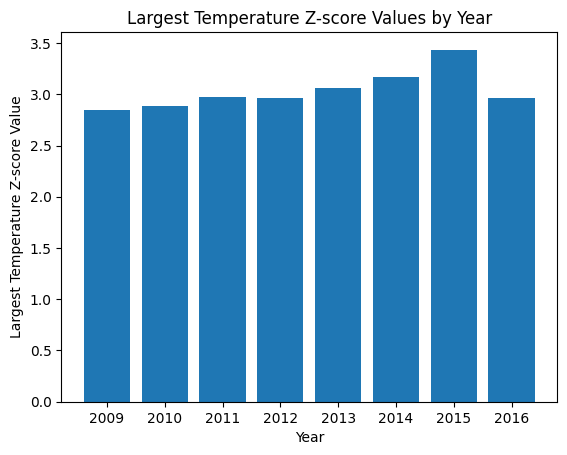

In [ ]:
import matplotlib.pyplot as plt

# Lists to hold years and largest z-scores
years = []
max_z_scores = []

for year in range(2009, 2017):
    # Getting the correct variable name based on the year
    z_scores_var_name = f'temp_z_scores{year}'
    z_scores_data = globals()[z_scores_var_name]

    # Finding the largest z-score
    max_z_score = max(z_scores_data)

    # Append year and max_z_score to the lists
    years.append(year)
    max_z_scores.append(max_z_score)

# create a bar plot
plt.bar(years, max_z_scores)

# title and labels
plt.title('Largest Temperature Z-score Values by Year')
plt.xlabel('Year')
plt.ylabel('Largest Temperature Z-score Value')

plt.show()


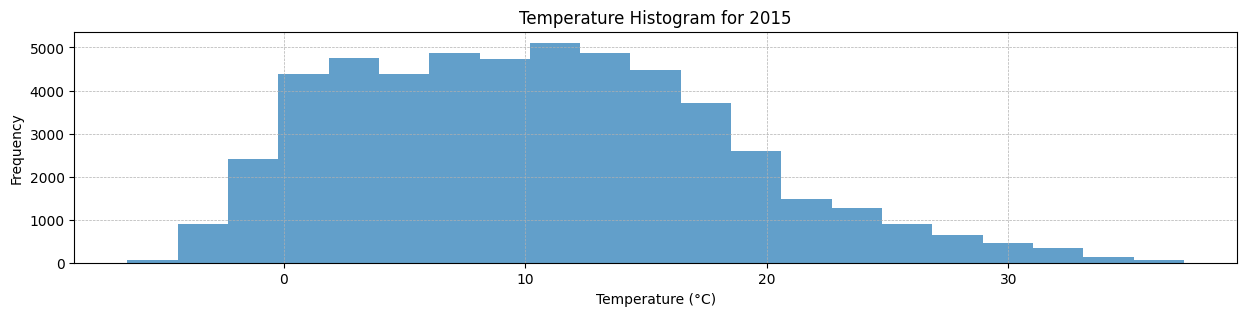

In [ ]:
year = 2015
temp_var_name = f'temp{year}'
temp_data = globals()[temp_var_name]

plt.figure(figsize=(15, 3))
plt.hist(temp_data, bins=21, alpha=0.7)
plt.title(f'Temperature Histogram for {year}')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


You can change the 2015 to any other year to obtain the histogram for that year.

# Anomaly Detection Method 3: CBLOF

Reading Data:


Take two separate variables from the data set with clear correlations. The variable sets used are:

  1.   Temperature and Specific Humidity
  2.   Temperature and Wind Speed
  3.   Temperature and Dew Point

Reformating the data points between 0 and 1. This allows us to determine a threshold value to classify inliers and outliers.




In [ ]:
data = pd.read_csv(csv_path)
data['Date Time']=pd.to_datetime(data['Date Time'])
data.set_index('Date Time').head(2)
data1=data[data['Date Time'].between('01.01.2013','31.12.2013 ')]
minmax = MinMaxScaler(feature_range=(0, 1))

data1[['T (degC)','sh (g/kg)']] = minmax.fit_transform(data1[['T (degC)','sh (g/kg)']])
data1[['T (degC)','sh (g/kg)']].head()

data[['T (degC)','sh (g/kg)']] = minmax.fit_transform(data[['T (degC)','sh (g/kg)']])
data[['T (degC)','sh (g/kg)']].head()

X1 = data1['T (degC)'].values.reshape(-1,1)
X2 = data1['sh (g/kg)'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)

XX = data['T (degC)'].values.reshape(-1,1)
XY = data['sh (g/kg)'].values.reshape(-1,1)
XN = np.concatenate((XX,XY),axis=1)

* Data points are extracted into arrays relating to a specific year from the data set. Variables are established for the whole data set as well as specific years.
* Establish the threshold value to include the outer 1% of the data points.
*   Fit the CBLOF package imported during the setup. Data points below this threshold are inliers and outside are outliers.
*   Counted the data arrays for inliers and outliers.

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(XN)

# predict raw anomaly score
scores_pred1 = clf.decision_function(XN) * -1

# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
n_init=10
df1 = data1
df1['outlier'] = y_pred.tolist()

inliers_1 = np.array(df1['T (degC)'][df1['outlier'] == 0]).reshape(-1,1)
inliers_2 = np.array(df1['sh (g/kg)'][df1['outlier'] == 0]).reshape(-1,1)

outliers_1 = df1['T (degC)'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_2 = df1['sh (g/kg)'][df1['outlier'] == 1].values.reshape(-1,1)

<Figure size 800x800 with 0 Axes>

Anomaly Score:
*   Calculated based on the size of the nearest cluster and the distance to it, for each data point.
*   Threshold value is the limit of the anomaly score for the data point to be considered an inlier.


In [ ]:
# Use threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred1, 100 * outliers_fraction)


# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

Formatting the plot:
*   Purple contour lines indicate the increasing anomaly score from the threshold
*   Green contour line indicates the points at which the anomaly score is equal to the threshold value.
*   Pink contour indicates the region where the anomaly score is below the threshold value.

1105


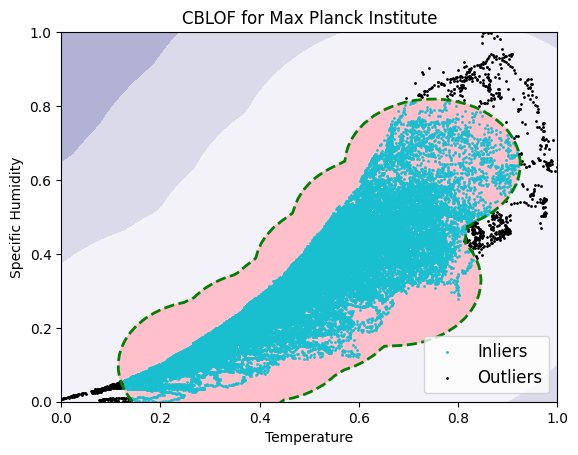

In [ ]:
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Purples_r)
plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='green')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='pink')

b = plt.scatter(inliers_1, inliers_2, c='white',s=1, edgecolor='tab:cyan')
c = plt.scatter(outliers_1, outliers_2, c='black',s=1, edgecolor='k')
print(len(outliers_1+outliers_2))

plt.axis('tight')
plt.legend([b,c], ['Inliers','Outliers'], prop=matplotlib.font_manager.FontProperties(size=12),loc='lower right')
plt.xlim((-0, 1))
plt.ylim((-0, 1))
plt.xlabel('Temperature')
plt.ylabel('Specific Humidity')
plt.title('CBLOF for Max Planck Institute')
plt.show()

Process is repeated for other relationships.

# Anomaly Detection Method 4: Autoencoder

Within the autoencoder machine learning model, there are two core components: the encoder and decoder. The encoder reduces high-dimensional data to a lower-dimensional representation, and the decoder attempts to reconstruct it. This autoencoder is utilized for anomaly detection by evaluating the accuracy of data reconstruction. Three main classes are involved: Data Pre-processing, Encoder (comprising encoder and decoder models), and Anomaly Detector (measuring reconstruction loss to identify anomalies).

source: tensorflow tutorial (https://www.tensorflow.org/tutorials/generative/autoencoder)

## Import dependencies

In [ ]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Format the data

The other anomaly detection methods have highlighted temperature as a useful feature for detecting anomalous weather patterns. Therefore, we will detect anomalies in temperature patterns. The Z-score anomaly detection method higheted that the temperature data for the years 2014 and 2015 had a score greater than 3 and so could be considered anaomalous. Therefore, days from these years were considered anomalous and labelled "1". whereas days from all other years were considered nonanomalous and labelled "0".

In [ ]:
# split the data into two subsets based on the labels (0 and 1)
df_label_0 = full_temp_df[full_temp_df['labels'] == 0]
df_label_1 = full_temp_df[full_temp_df['labels'] == 1]


# split each subset into training and testing sets separately
X_train_label_0, X_test_label_0, y_train_label_0, y_test_label_0 = train_test_split(
    df_label_0.iloc[:, :-1], df_label_0.iloc[:, -1], test_size=0.2, random_state=42)

X_train_label_1, X_test_label_1, y_train_label_1, y_test_label_1 = train_test_split(
    df_label_1.iloc[:, :-1], df_label_1.iloc[:, -1], test_size=0.2, random_state=42)

# Concatenate the training and testing sets for both labels to get the final splits
X_train = pd.concat([X_train_label_0, X_train_label_1])
X_test = pd.concat([X_test_label_0, X_test_label_1])
y_train = pd.concat([y_train_label_0, y_train_label_1])
y_test = pd.concat([y_test_label_0, y_test_label_1])



In [ ]:
# normalise the data between [0,1]
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
# also normalise the seperated anomaould and nonanomalous datasets
X_train_label_0 = pd.DataFrame(scaler.fit_transform(X_train_label_0), columns=X_train_label_0.columns)
X_train_label_1 = pd.DataFrame(scaler.fit_transform(X_train_label_1), columns=X_train_label_1.columns)
X_test_label_0  = pd.DataFrame(scaler.fit_transform(X_test_label_0), columns=X_test_label_0.columns)
X_test_label_1  = pd.DataFrame(scaler.fit_transform(X_test_label_1), columns=X_test_label_1 .columns)

The autoencoder is trained on only the nonanomalous days, which have the label 1. So we use only the training data for the nonanomalous days: X_train_label_0

Plot an anomalous day

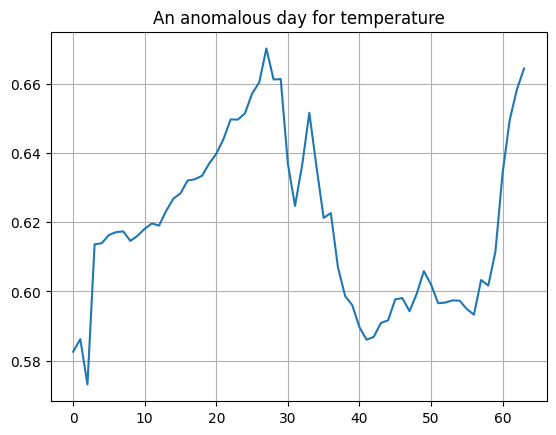

In [ ]:
plt.grid()
plt.plot(X_train_label_1.iloc[0],linestyle='-')
plt.title("An anomalous day for temperature")
plt.show()

Plot a nonanomalous day

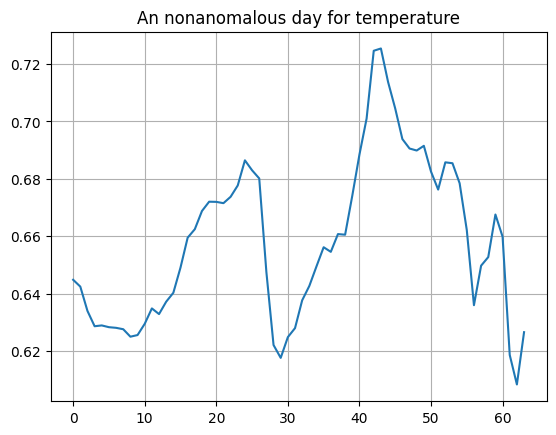

In [ ]:
plt.grid()
plt.plot( X_train_label_0.iloc[0])
plt.title("An nonanomalous day for temperature")
plt.show()

## Build the model

In [ ]:
# we built the model using the keras API
from tensorflow import keras

In [ ]:
# Define the dimensions

input_dim = X_train_label_0.shape[1] # input data dimension
encoding_dim = 8 # dimension of the encoded data

# Encoder
input_layer = keras.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation= 'relu')(input_layer)

# Decoder
decoder = keras.layers.Dense(input_dim, activation='sigmoid')(encoder)

# Create the autoencoder model
autoencoder = keras.Model(inputs=input_layer,outputs=decoder)
autoencoder.compile(optimizer='adam',loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train_label_0,X_train_label_0, epochs=100, batch_size=64, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100
28/28 [==============================] - 1s 11ms/step - loss: 0.0372 - val_loss: 0.0392
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0378
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0331 - val_loss: 0.0357
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.0330
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0302
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0277
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.0255
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0200 - val_loss: 0.0239
Epoch 9/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0222
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0172 - val_loss: 0.0209
Epoch 11

<function matplotlib.pyplot.legend(*args, **kwargs)>

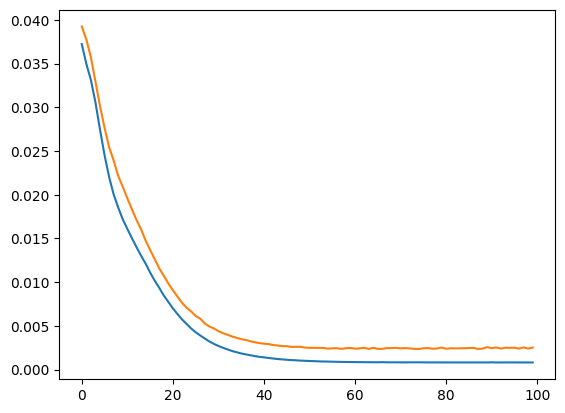

In [ ]:
# Plot the training curves

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend

## Detect Anomalies

Anomalies are deteced by calculating the reconrstuction loss. If the loss is greater than a set threshold, then a years weather is detected as an anomaly.
The threshold is decided in this way:
*   Calucate the mean average error for normal weather-years
*   Classify any weather years as anomalous if the reconstruction error is higher than one standard dviation from the normal weather-years




55/55 [==============================] - 0s 1ms/step


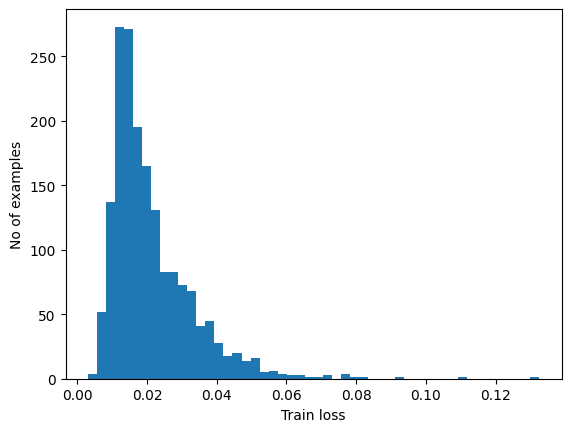

In [ ]:
# plot the recontrustion error on normal weather years
reconstructions = autoencoder.predict(X_train_label_0)
train_loss = tf.keras.losses.mae(reconstructions, X_train_label_0)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

5/5 [==============================] - 0s 2ms/step


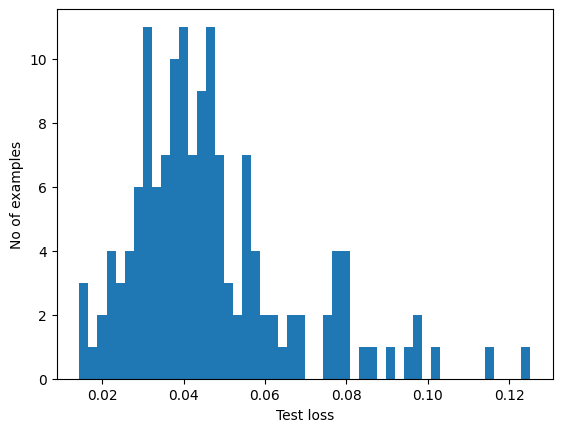

In [ ]:
# plot the recontrustion error on anomalous weather years
reconstructions = autoencoder.predict(X_test_label_1)
test_loss = tf.keras.losses.mae(reconstructions, X_test_label_1)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# select threshold value
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.033213876724640684


In [ ]:
# classify a weather-year as an anomaly if the reconstruction error is greater than the threshold

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, X_test, threshold)
print_stats(preds, y_test)

AttributeError: ignored